Link Huggingface: 
https://huggingface.co/spaces/edwinrdrr/P1M2

# Perkenalan

## Perkenalan Diri

Nama : Edwin Reyhan Devara Ramadhan Rasya  
Batch : FTDS-017-RMT

## Pengenalan Dataset

Dataset yang kita pakai adalah data pemesan kamar hotel yang terdiri dari id booking kamar, jumlah orang dewasa dan anak kecil yang akan menginap, jenis makanan yang diinginkan dan lain-lain. Dataset ini memiliki 19 informasi (features) dari 36275 pemesan (observations atau rows). Dataset ini diperuntukkan untuk melakukan klasifikasi apakah pemesan melakukan pembatalan kamar atau tidak.

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

Dataset dan pendefinisian features diambil dari:  
https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

## Objective

Hotel sudah sering kali mengalami kerugian karena pemesan kamar yang secara tiba-tiba melakukan pembatalan terhadap kamar yang dipesan. Kita sebagai data scientist perusahaan hotel ini ingin mencari tahu apa penyebab dari pembatalan itu dan memprediksi apakah seorang pemesan kamar akan melakukan pembatalan kamar atau tidak. Hal ini dapat kita lakukan dengan membuat sebuah model yang akan melakukan klasifikasi apakah seseorang yang baru saja pesan kamar akan melakukan pembatalan atau tidak di kemudian hari. Karena kita ingin menekan angka kerugian yang disebabkan oleh pemesan kamar melakukan pembatalan, kita menginginkan model kita akurat dalam melakukan prediksi terhadap orang yang akan melakukan pembatalan dan orang-orang yang melakukan pembatalan tersebut tidak terklasifikasikan sebagai orang yang tidak akan melakukan pembatalan (**False Negative**), yang mana akan menyebabkan kerugian di kemudian hari.   
Maka dari itu, kita akan membuat sebuah model yang mempunyai score recall tinggi dan dapat menekan jumlah orang masuk False Negative. Namun kita juga tidak ingin mempunyai False Positive yang terlalu banyak juga, karena ketika kita melakukan klarifikasi akan membuat hotel kita menggangu pemesan kamar yang sebenarnya tidak akan melakukan pembatalan.    
Fokus Metric : False Negative dan Recall

# Import Libraries

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pickle
import json
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB, ComplementNB, ClassifierMixin
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Data Loading

In [2]:
# Data loading with read_csv
data_raw = pd.read_csv('Hotel Reservations.csv')
data_raw.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [3]:
# melihat jumlah rows, columns, dan data typenya
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

# EDA

In [4]:
# copy data for eda purpose
data_eda = data_raw.copy()

## Check numerical and categorical features

In [5]:
data_eda.select_dtypes(include=np.number).head(2)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,2,0,1,2,0,224,2017,10,2,0,0,0,65.00,0
1,2,0,2,3,0,5,2018,11,6,0,0,0,106.68,1


**Discrete Features (Feature yang nilainya dapat dihitung bulat)**:  
'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'arrival_year', 'arrival_month', 'arrival_date','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'lead_time'.  

**Continuous Features (Feature yang nilainya sangat detail dengan angka yang lebih spesifik di belakang koma)**:  
'avg_price_per_room'

**Numerical Features that are encoded (binary yes/no, nilainya mempunyai level namun tidak bisa ditambah maupun dikurang, tapi nilai feature ini sudah berbentuk angka)**:  
'required_car_parking_space', 'repeated_guest'

In [6]:
data_eda.select_dtypes(include='object').head(2)

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,INN00001,Meal Plan 1,Room_Type 1,Offline,Not_Canceled
1,INN00002,Not Selected,Room_Type 1,Online,Not_Canceled


**Nominal category (Nilai yang tidak punya level)**:  
'Booking_ID'  

'Booking_ID' akan dihapus karena tidak dapat melakukan prediksi disebabkan oleh booking_id punya nilai yang berbeda semua.

**Ordinal category (Nilai yang punya level)**:  
'type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status'  

Feature-feature ini disebut ordinal karena:
* type of meal punya level harga
* room type juga mempunyai level harga
* market segment juga punya level harga

## Visualize Discrete Features

In [7]:
num_discrete = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'arrival_year', 'arrival_month', 'arrival_date','no_of_previous_cancellations', 'no_of_special_requests']

In [8]:
# dipisah karena punya sum x yang panjang
num_discrete_separate = ['no_of_previous_bookings_not_canceled', 'lead_time']

In [9]:
data_discrete = data_eda[num_discrete]

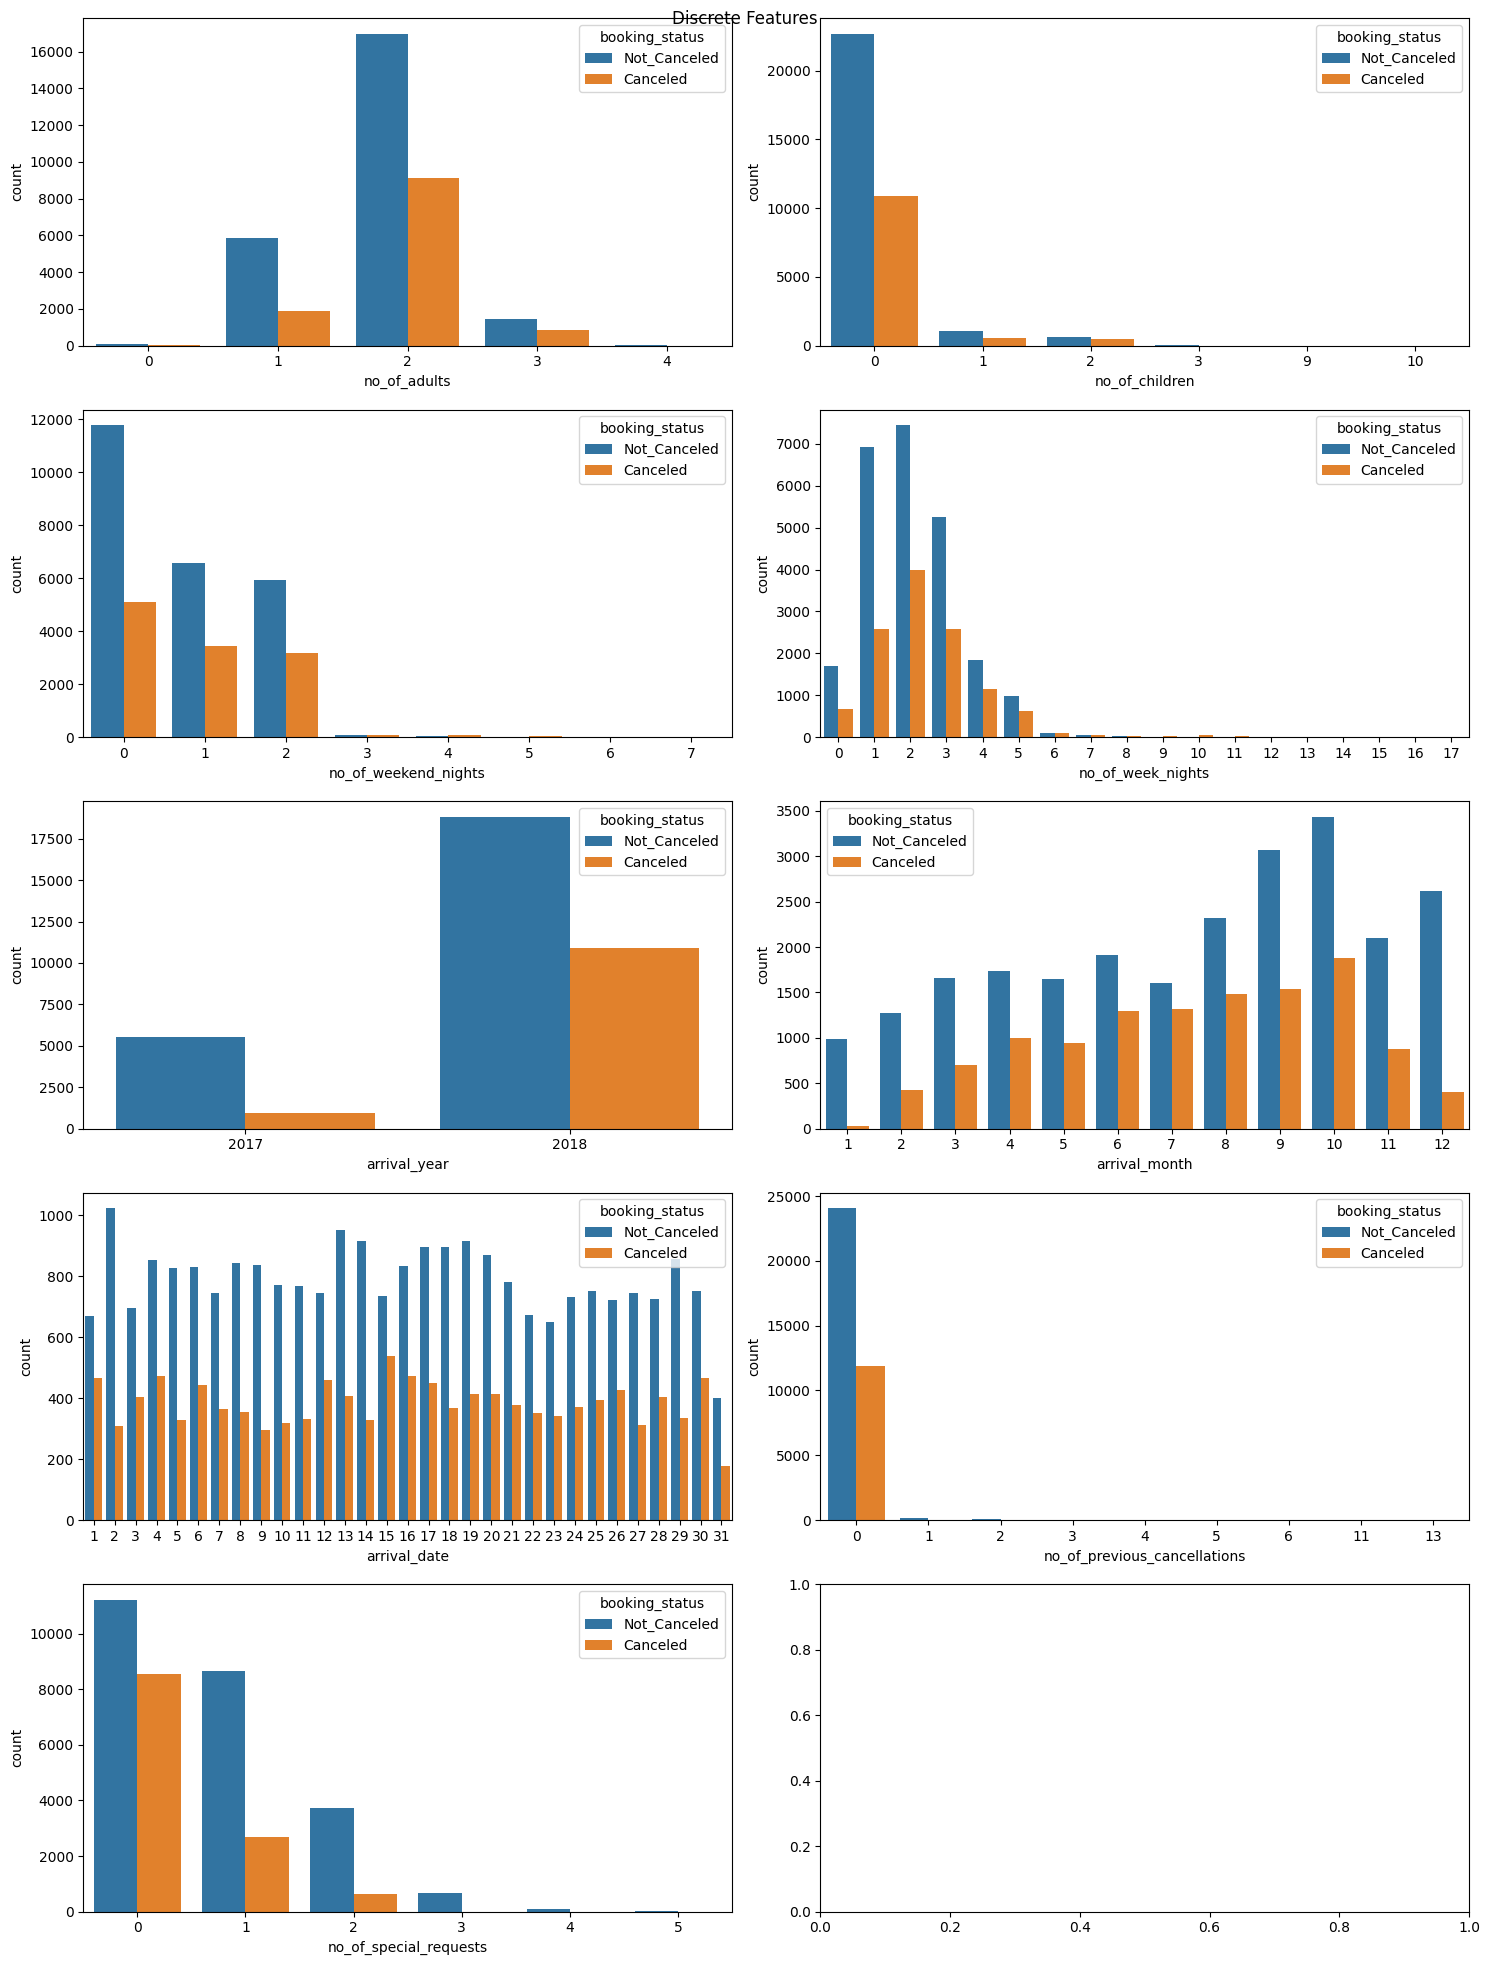

In [10]:
# melakukan visualisasi discrete numerical 
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Discrete Features')


for i, x in zip(range(0,2),range(0,2)):
    sns.countplot(ax=axes[0,i], data=data_eda, x=num_discrete[x], hue='booking_status')

for i, x in zip(range(0,2),range(2,4)):
    sns.countplot(ax=axes[1,i], data=data_eda, x=num_discrete[x], hue='booking_status')

for i, x in zip(range(0,2),range(4,6)):
    sns.countplot(ax=axes[2,i], data=data_eda, x=num_discrete[x], hue='booking_status')

for i, x in zip(range(0,2),range(6,8)):
    sns.countplot(ax=axes[3,i], data=data_eda, x=num_discrete[x], hue='booking_status')

for i, x in zip(range(0,2),range(8,9)):
    sns.countplot(ax=axes[4,i], data=data_eda, x=num_discrete[x], hue='booking_status')

    
fig.tight_layout()

Informasi mengenai berapa orang dewasa, anak-anak, apakah pesanan kamar ada di malam weekend, apakah di malam hari biasa, tahun, bulan, hari pesanan, apakah pemesan pernah melakukan pembatalan, dan apakah ada request khusus untuk pesanan tersebut seperti viewnya bagus, dll. tidak bisa membedakan apakah pemesan kamar akan melakukan pembatalan atau tidak. Hal ini ditunjukkan oleh tidak adanya perubahan pada grafik chart feature-feature tersebut, seperti semakin tinggi banyak orang dewasa yang menginap semakin tinggi kasus pembatalan dibandingkan tidak ada pembatalan. Sedangkan untuk feature-feature di atas, figure jumlah tidak melakukan pembatalan selalu berjumlah lebih besar dibandingkan jumlah melakukan pembatalan.

### Visualize previous booking not canceled and lead time separately

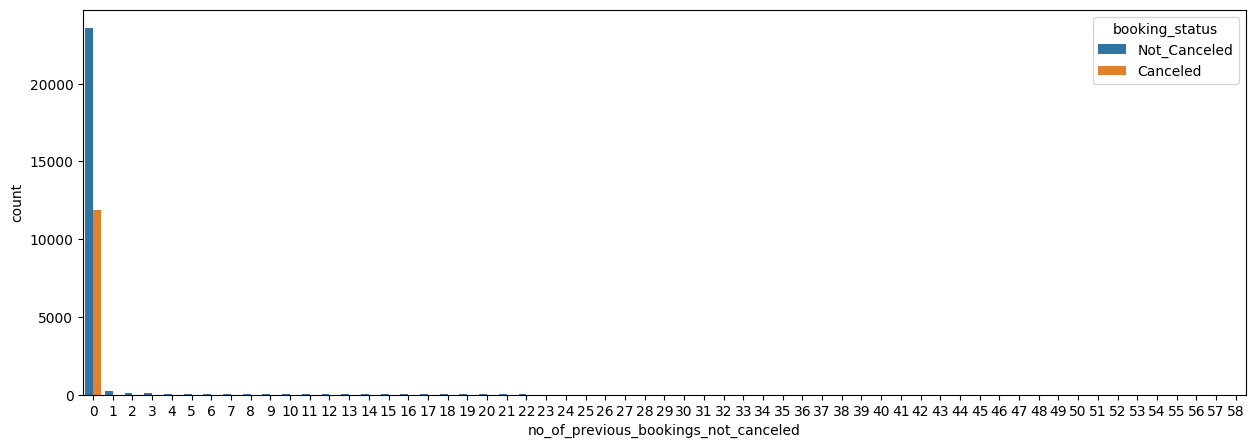

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.countplot(ax=ax, data=data_eda, x=data_eda['no_of_previous_bookings_not_canceled'], hue='booking_status');

Informasi apakah pemesan tidak pernah melakukan pembatalan terhadap pesanan-pesanan sebelumnya juga terlihat tidak dapat melakukan klasifikasi apakah pemesan melakukan pembatalan atau tidak.

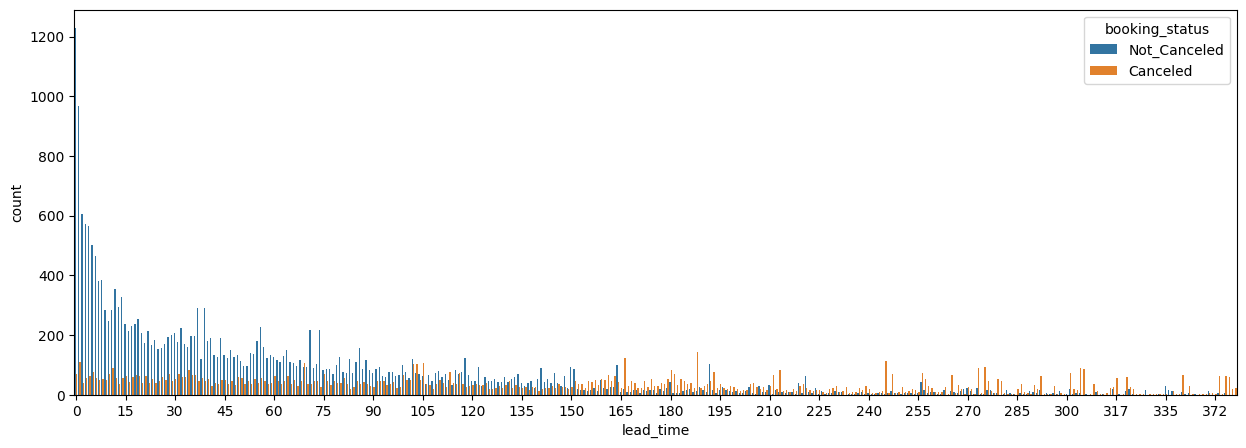

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.countplot(ax=ax, data=data_eda, x=data_eda['lead_time'], hue='booking_status')
ax.set_xticks(ax.get_xticks()[::15]);

Informasi jarak antara hari pemesanan dan hari menginap terlihat dapat melakukan klasifikasi apakah pemesan melakukan pembatalan atau tidak. Hal ini ditunjukkan oleh semakin jauh hari pemesanan dilakukan dari hari menginap, semakin besar pula kasus dimana pembatalan lebih banyak dari pada tidak melakukan pembatalan. Hal ini mungkin sering disebabkan oleh jadwal pemesan yang berubah, ada perubahan rencana, pemesan lupa, dll. Rekomendasi penulis terhadap perusahaan adalah sebaiknya pesanan-pesanan dengan jarak antara hari pemesanan dan menginap yang jauh dijadwalkan akan dihubungi untuk melakukan konfirmasi apakah jadi menginap di hari itu atau tidak. Jika tidak, kita bisa langsung merubah status kamar menjadi available pada hari itu.

## Visualize Continuous Features

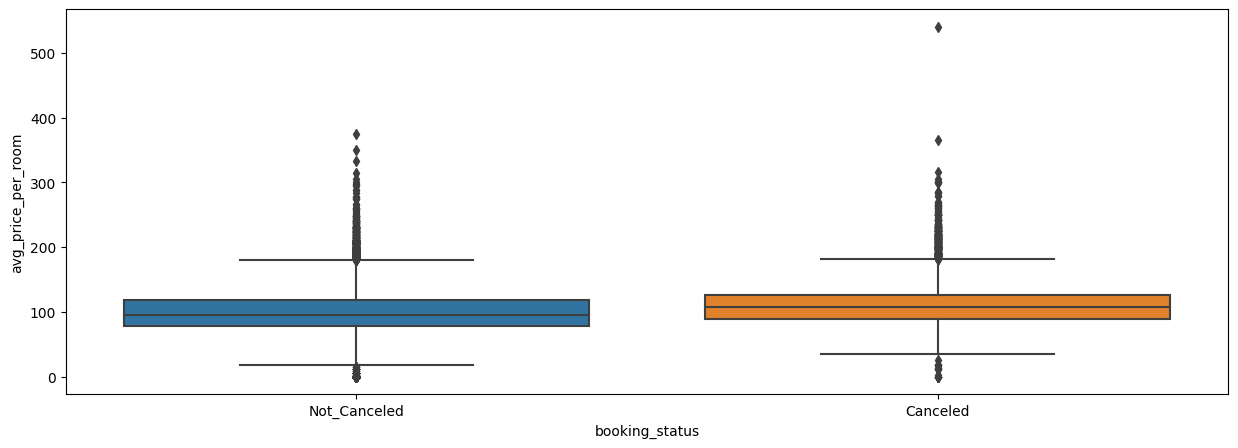

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.boxplot(ax=ax, x=data_eda['booking_status'], y=data_eda['avg_price_per_room']);

Distribusi harga kamar yang dipesan oleh penginap melakukan pembatalan dan tidak adalah hampir sama. Hal ini menunjukkan bahwa harga kamar tidak dapat melakukan klasifikasi apakah pemesan melakukan pembatalan atau tidak.

# Feature Engineering

In [14]:
# copy data for making machine learning
data = data_raw.copy()

## Train Test Split

In [15]:
# split data to X and y
X = data.drop('booking_status', axis=1)
y = data['booking_status']

In [16]:
# split data to Training Set to Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [17]:
y_train

899      Not_Canceled
14961        Canceled
15124        Canceled
2565     Not_Canceled
11024        Canceled
             ...     
26262        Canceled
28320    Not_Canceled
8351     Not_Canceled
4226         Canceled
31632    Not_Canceled
Name: booking_status, Length: 29020, dtype: object

In [18]:
# mengubah Not_Canceled ke 0 dan Canceled ke 1
y_train = np.where(y_train == 'Canceled', 1, 0)
y_train

array([0, 1, 1, ..., 0, 1, 0])

In [19]:
y_test

34697    Not_Canceled
33492    Not_Canceled
15748    Not_Canceled
34776    Not_Canceled
24584        Canceled
             ...     
21530    Not_Canceled
25889        Canceled
35220        Canceled
28376        Canceled
2405     Not_Canceled
Name: booking_status, Length: 7255, dtype: object

In [20]:
# mengubah Not_Canceled ke 0 dan Canceled ke 1
y_test = np.where(y_test == 'Canceled', 1, 0)
y_test

array([0, 0, 0, ..., 1, 1, 0])

## X_train

### Handling Outliers

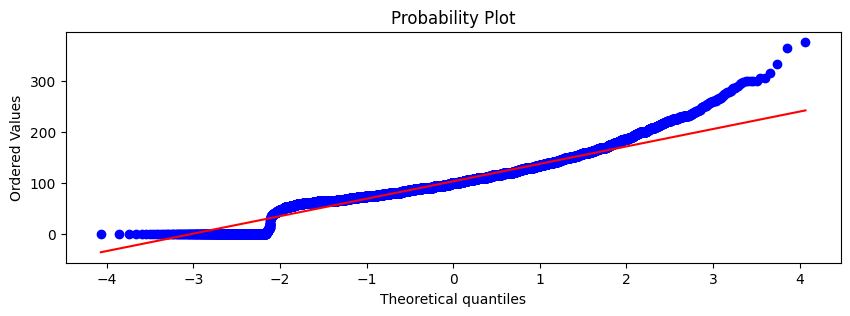

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
st.probplot(plot=ax, dist="norm", x=X_train['avg_price_per_room']);

Karena data points dari harga kamar tidak berada pada titik merah lurus, feature harga kamar dapat dikatakan memiliki distribusi data yang tidak normal.

In [22]:
data_series = X_train['avg_price_per_room']
q1, q3 = np.percentile(data_series, 25), np.percentile(data_series, 75)
iqr = q3 - q1
cut_off = iqr * 1.5
lower, upper = q1 - cut_off, q3 + cut_off
jumlah = ((data_series < lower) | (data_series > upper)).sum()
outliers_below_lower = data_series[data_series < lower].index
outliers_over_upper = data_series[data_series > upper].index
    
print(f'Maximum outlier of {data_series.name} is {(data_series[outliers_over_upper].max() / upper):.2f} times larger than upper boundary')
print(f'Minimun outlier of {data_series.name} is {(data_series[outliers_below_lower].min() / lower):.2f} times smaller than lower boundary')
print('')

Maximum outlier of avg_price_per_room is 2.09 times larger than upper boundary
Minimun outlier of avg_price_per_room is 0.00 times smaller than lower boundary



In [23]:
# upper limit dari harga kamar
upper

179.55

In [24]:
# mengubah outliers di luar upper limit menjadi angka yang ada di upper
X_train.loc[outliers_over_upper,'avg_price_per_room'] = upper

Outliers di luar upper boundary akan kita ganti dengan harga yang ada pada upper boundary.

### Handling Duplicated

In [25]:
# melihat apakah ada rows yang duplikasi
X_train[X_train.duplicated()]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests


X_train tidak memiliki duplikasi baris

### Handling Missing Values

In [26]:
# melihat apakah ada missing value atau tidak di X_train
X_train.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

In [27]:
# melihat apakah ada missing value atau tidak di y_train
np.count_nonzero(np.isnan(y_train))

0

X_train maupun y_train tidak ada missing values

## X_test

### Handling Duplicated

In [28]:
# melihat apakah ada rows yang duplikasi
X_test[X_test.duplicated()]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests


X_test tidak memiliki duplikasi baris

### Handling Missing Values

In [29]:
# melihat apakah ada missing value atau tidak di X_test
X_test.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

In [30]:
# melihat apakah ada missing value atau tidak di y_test
np.count_nonzero(np.isnan(y_test))

0

X_test maupun y_test tidak memiliki missing values

# Pipeline (Preparation) (Scaling, Encoding, Feature Selection)

## X_train

### Creating Pipe for scaling, encoding, and feature selection

In [31]:
# numerical columns that will be passed on to numerical pipe
num_columns = ['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

In [32]:
# categorical columns that will be passed on to categorical pipe
cat_columns = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type', 'repeated_guest']

In [33]:
# make numerical columns consist of scaler, and anova F-value to select the best features
pipe_num = Pipeline([
    ("scaler",StandardScaler()),
    ("f_classif",SelectKBest(f_classif, k = 1))
])

# make categorical columns consist of encoder, and chi2 to select the best features
pipe_cat = Pipeline([
    ("encode",OrdinalEncoder()),
    ("chi2",SelectKBest(chi2, k = 2))
])

Ketika categorical = 2 features, numerical features lebih dari 1 dapat mengakibatkan recall Naive Bayes turun, namun beberapa model lain naik.  
Ketika numerical = 1 feature dan categorical features lebih dari 2 dapat mengakibatkan recall Naive Bayes turun, namun beberapa model lain naik.  
Ketika numerical = 1 feature dan categorical feature juga 1 dapat mengakibatkan recall Naive Bayes turun dan beberapa model lain juga turun.

### Feature Selection

In [34]:
# menggabungkan pipe untuk categorical dan numerical beserta feature-featurenya
pipe_preprocessing_best = make_column_transformer(
    (pipe_num, num_columns),
    (pipe_cat, cat_columns)
)

In [35]:
pipe_preprocessing_best.fit(X_train, y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('f_classif',
                                                  SelectKBest(k=1))]),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'lead_time', 'arrival_year', 'arrival_month',
                                  'arrival_date',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'avg_price_per_room',
                                  'no_of_special_requests']),
                                ('pipeline-2',
                                 Pipeline(steps=[('encode', OrdinalEncoder()),
                                                 ('chi2',
                                                  SelectKBest(k=2,
                                                              score_func=<function chi2 at 0x000001CCF85F6C00>))]),
                                 ['type_of_meal_plan',
                                  'required_car_parking_space',
                                  'room_type_reserved', 'market_segment_type',
                                  'repeated_guest'])])

In [36]:
# melakukan transform untuk data training untuk training model
X_train_transformed = pipe_preprocessing_best.transform(X_train)

#### Numerical Features (with f_classif)

In [37]:
# mendapatkan score masing-masing feature numerical
f_classif_scores = pipe_preprocessing_best.named_transformers_['pipeline-1']['f_classif'].scores_

In [38]:
# melihat score masing-masing feature numerical
pd.DataFrame({'features': num_columns, 
              'scores':f_classif_scores}).sort_values('scores',ascending = False)

,features,scores
4,lead_time,6777.207918
11,no_of_special_requests,1971.619297
5,arrival_year,985.246203
10,avg_price_per_room,666.147723
0,no_of_adults,225.367025
3,no_of_week_nights,219.159046
2,no_of_weekend_nights,116.015802
9,no_of_previous_bookings_not_canceled,103.840482
8,no_of_previous_cancellations,31.345598
1,no_of_children,28.189127


Informasi mengenai jarak antara pemesanan dan menginap adalah satu-satunya feature numerical yang akan kita masukkan ke model kita. Kenapa satu numerical feature saja? Karena satu numerical feature dan 2 categorical feature adalah kombinasi terbaik untuk performance model kita berdasarkan recall score.

#### Categorical Features (with chi2)

In [39]:
# mendapatkan score masing-masing feature categorical
chi2_scores = pipe_preprocessing_best.named_transformers_['pipeline-2']['chi2'].scores_

In [40]:
# melihat score masing-masing feature categorical
pd.DataFrame({'features': cat_columns, 
              'scores':chi2_scores}).sort_values('scores',ascending = False)

,features,scores
4,repeated_guest,328.792618
1,required_car_parking_space,219.369513
3,market_segment_type,71.510178
0,type_of_meal_plan,59.072121
2,room_type_reserved,44.457873


Informasi mengenai apakah pemesan adalah tamu yang pernah menginap di hotel itu dan apakah mereka membutuhkan lahan parkir atau tidak adalah dua features yang akan kita masukkan ke dalam model kita. Jika kita memilih kurang atau lebih dari 2 features, maka kita akan membuat performa model kita turun berdasarkan recall score.

## X_test

In [41]:
# melakukan transformasi data testing untuk melakukan evaluasi model
X_test_transformed = pipe_preprocessing_best.transform(X_test)

# Cross Validation to choose the best base model 

In [42]:
skfold=StratifiedKFold(n_splits=5)

In [43]:
# inisiasi model-model yang ingin dipakai
log = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
nb  = GaussianNB()
dt  = DecisionTreeClassifier(random_state=0)
rf  = RandomForestClassifier(random_state=0)
ab  = AdaBoostClassifier(random_state=0)

In [44]:
# melakukan cross validation
log_cross = cross_val_score(log, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')
knn_cross = cross_val_score(knn, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')
nb_cross  = cross_val_score(nb, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')
svc_cross  = cross_val_score(svc, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')
dt_cross  = cross_val_score(dt, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')
rf_cross  = cross_val_score(rf, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')
ab_cross  = cross_val_score(ab, X=X_train_transformed, y=y_train, cv=skfold, scoring='recall')

In [45]:
# membuat dataframe untuk membanding recall score yang didapat masing-masing model
the_dict = {
    'log':log_cross,
    'knn':knn_cross,
    'nb' :nb_cross,
    'svm':svc_cross,
    'dt':dt_cross,
    'rf':rf_cross,
    'ab':ab_cross
           }
recall_dataframe = pd.DataFrame.from_dict(the_dict, orient='index')


the_mean_dict = {
    'log':log_cross.mean(),
    'knn':knn_cross.mean(),
    'nb' :nb_cross.mean(),
    'svm':svc_cross.mean(),
    'dt':dt_cross.mean(),
    'rf':rf_cross.mean(),
    'ab':ab_cross.mean()
           }
the_mean_series = pd.Series(the_mean_dict)
recall_dataframe['mean'] = the_mean_series


the_std_dict = {
    'log':log_cross.std(),
    'knn':knn_cross.std(),
    'nb' :nb_cross.std(),
    'svm':svc_cross.std(),
    'dt':dt_cross.std(),
    'rf':rf_cross.std(),
    'ab':ab_cross.std()
           }
the_std_series = pd.Series(the_std_dict)
recall_dataframe['std'] = the_std_series

In [46]:
# membuat dataframe untuk membanding recall score yang didapat masing-masing model
recall_dataframe.sort_values('mean', ascending=False)

,0,1,2,3,4,mean,std
nb,0.991057,0.989479,0.989485,0.991588,0.989485,0.990219,0.000917
knn,0.422935,0.482378,0.500526,0.478444,0.481598,0.473176,0.026289
rf,0.441873,0.454498,0.455836,0.451630,0.455310,0.451829,0.005186
dt,0.440821,0.452393,0.447950,0.448475,0.443218,0.446571,0.004092
svm,0.427670,0.434508,0.417981,0.433754,0.426919,0.428166,0.005949
log,0.420831,0.432404,0.411672,0.430599,0.425868,0.424275,0.007474
ab,0.419779,0.424513,0.406940,0.427445,0.423239,0.420383,0.007158


Dari tujuh model yang sudah kita pilih untuk dicoba dengan training set, hanya model Naive Bayes yang memiliki rata-rata recall score lebih dari 50%. Maka dari itu model yang akan kita pakai untuk membantu kita melakukan klasifikasi apakah pemesan akan membatalkan pesanannya atau tidak adalah Naive Bayes. 

# Model Improvement or tuning with GridSearch

In [47]:
n_classes = np.unique(y_train)

In [48]:
params = {
#     'gaussiannb__priors': [None, [0.1,]* len(n_classes),],
    'var_smoothing': [0.000000001,0.00000001,0.0000001,0.0000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]
}

In [49]:
nb_grid = GridSearchCV(estimator=nb, param_grid=params, n_jobs=-1, cv=skfold, verbose=1, scoring='recall')
nb_grid.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-07, 1e-07,
                                           1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                           0.1]},
             scoring='recall', verbose=1)

In [50]:
nb_grid.best_estimator_

GaussianNB()

# Naive Bayes Base Model vs Tuned Naive Bayes Model

>**Base Model (Sebelum Hyperparameter Tuning)**

In [51]:
nb_base = GaussianNB()
nb_base.fit(X_train_transformed, y_train)
y_hat_nb_base_train = nb_base.predict(X_train_transformed)

In [52]:
print(classification_report(y_train, y_hat_nb_base_train))

              precision    recall  f1-score   support

           0       0.94      0.07      0.13     19512
           1       0.34      0.99      0.51      9508

    accuracy                           0.37     29020
   macro avg       0.64      0.53      0.32     29020
weighted avg       0.74      0.37      0.26     29020



> **Tuned Naive Bayes (Setelah Hyperparameter Tuning)**

In [53]:
y_hat_nb_grid_train = nb_grid.predict(X_train_transformed)

In [54]:
print(classification_report(y_train, y_hat_nb_grid_train))

              precision    recall  f1-score   support

           0       0.94      0.07      0.13     19512
           1       0.34      0.99      0.51      9508

    accuracy                           0.37     29020
   macro avg       0.64      0.53      0.32     29020
weighted avg       0.74      0.37      0.26     29020



Tidak ada improvement pada recall score model naive bayes. Kita juga bisa melihat bahwa score-score selain recall score juga tidak mengalami perubahan.   

# Model Generalization to Testing Set

## Berapa Gap antara Recall, Precision di Training Set dan Recall, Precision Testing Set?

In [55]:
y_hat_nb_grid_train = nb_grid.predict(X_train_transformed)
y_hat_nb_grid_test = nb_grid.predict(X_test_transformed)

recall_nb_grid_train = recall_score(y_train, y_hat_nb_grid_train)
recall_nb_grid_test = recall_score(y_test, y_hat_nb_grid_test)

precision_nb_grid_train = precision_score(y_train, y_hat_nb_grid_train)
precision_nb_grid_test = precision_score(y_test, y_hat_nb_grid_test)

In [56]:
pd.DataFrame({'Recall':[recall_nb_grid_train, recall_nb_grid_test],
             'Precision':[precision_nb_grid_train, precision_nb_grid_test],
             }, 
             index=['Train Set', 'Test Set'])

,Recall,Precision
Train Set,0.990219,0.342177
Test Set,0.984434,0.341855


Model Naive Bayes kita dapat melakukan generalisasi ke testing set dengan baik. Model kita hanya mempunyai gap 0.5% pada recall score training set dan testing set, lalu 0% gap pada precision score. Hal ini dapat membuktikan bahwa model kita adalah **good fit.** Model dengan recall score dan generalisasi yang bagus ini dapat membantu bisnis hotel kita karena jika kita memasukkan unseen data ke model ini kita dapat melakukan klasifikasi dengan akurat dan kemungkinam kita salah dalam melakukan klasifikasi pemesan yang punya kemungkinan untuk cancel kamar yang dipesan (False Negative) sangatlah kecil. Hal ini juga dapat memenuhi objective awal kita untuk mengurangi kerugian hotel karena banyak pemesan yang tiba-tiba melakukan pembatalan.

## Melihat grafik train score dan test score dengan nilai var_smoothing yang berbeda (memakai base model)

1e-09, 0.990, 0.984
1e-08, 0.990, 0.984
1e-07, 0.990, 0.984
1e-07, 0.990, 0.984
1e-07, 0.990, 0.984
1e-06, 0.990, 0.984
1e-05, 0.990, 0.984
0.0001, 0.990, 0.984
0.001, 0.990, 0.984
0.01, 0.625, 0.645
0.1, 0.432, 0.449


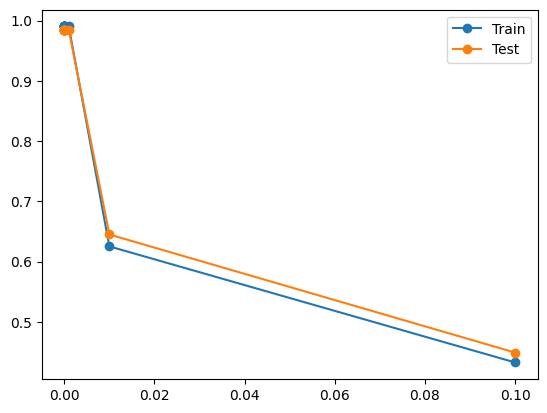

In [57]:
train_scores = []
test_scores = []
var_smoothing = [0.000000001,0.00000001,0.0000001,0.0000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]
# var_smoothing = [0.0000000014242,0.00000001422556,0.000000175743,0.0000001313131,0.0000001414121,0.000001552522,0.00001131312,0.0001313131,0.0013131131,0.011313131,0.143435]

for i in var_smoothing:
    model = GaussianNB(var_smoothing=i)
    model.fit(X_train_transformed, y_train)
    y_train_hat = model.predict(X_train_transformed)
    train_acc = recall_score(y_train, y_train_hat)
    train_scores.append(train_acc)

    y_test_hat = model.predict(X_test_transformed)
    test_acc = recall_score(y_test, y_test_hat)
    test_scores.append(test_acc)
    
    print(f'{i}, {train_acc:.3f}, {test_acc:.3f}')

plt.plot(var_smoothing, train_scores, '-o', label='Train')
plt.plot(var_smoothing, test_scores, '-o', label='Test')
plt.legend();

Source : https://machinelearningmastery.com/overfitting-machine-learning-models/

Dari grafik di atas, kita bisa melihat bahwa dengan model kita dicoba menggunakan nilai var_smoothing yang berbeda-beda, model kita memiliki performa yang hampir sama pada training set dan testing set. Hal ini menunjukkan bahwa model kita **good fit.**

# False Negative Analysis

In [58]:
X_train_postive_negative = X_train.copy()
X_train_postive_negative.loc[:,'y_true'] = y_train
X_train_postive_negative.loc[:,'y_pred'] = y_hat_nb_grid_train
# X_train_postive_negative['is_positive'] = np.where(X_train_postive_negative.y == 1, 'positive', 'negative')

In [59]:
def _point_status(row):    
    if (row['y_true'] == 0) & (row['y_pred'] == 0):
        point = 'TN'
    elif (row['y_true'] == 0) & (row['y_pred'] == 1):
        point = 'FP'
    elif (row['y_true'] == 1) & (row['y_pred'] == 1):
        point = 'TP'
    elif (row['y_true'] == 1) & (row['y_pred'] == 0):
        point = "FN"
        
    return point

In [60]:
X_train_postive_negative['point_status'] = X_train_postive_negative.apply(_point_status, axis=1)

In [61]:
X_train_postive_negative_selected = X_train_postive_negative[['lead_time', 'repeated_guest', 'required_car_parking_space', 'y_true', 'y_pred', 'point_status']]

In [62]:
X_train_postive_negative_selected.groupby('point_status').agg({'lead_time':'mean'})

,lead_time
point_status,
FN,194.784946
FP,61.540166
TN,25.215297
TP,137.840998


Informasi mengenai jarak hari pemesanan dan menginap tidak membuat model kita salah klasifikasi. Hal tersebut dapat ditunjukkan dengan karakteristik False Negative dan True Positive yang sama, yaitu memiliki rata-rata jarak hari pemesanan dan menginap yang jauh sekali.

In [63]:
X_train_postive_negative_selected.groupby('point_status').agg({'repeated_guest':'sum'})

,repeated_guest
point_status,
FN,13
FP,0
TN,739
TP,0


Informasi mengenai apakah pemesan adalah tamu yang pernah menginap di hotel kita atau tidak adalah informasi yang dapat membuat model kita bingung atau salah dalam melakukan klasifikasi kasus positive menjadi kasus negative (False Negative). Pada informasi ini, pemesan-pemesan yang masuk False Negative dan kasus negative memiliki karakteristik yang sama yaitu mereka adalah tamu yang pernah menginap di hotel kita.

In [64]:
X_train_postive_negative_selected.groupby('point_status').agg({'required_car_parking_space':'sum'})

,required_car_parking_space
point_status,
FN,80
FP,0
TN,790
TP,0


Informasi mengenai apakan pemesan kamar membutuhkan lahan parkir atau tidak adalah informasi yang juga dapat membuat model kita salam dalam melakukan klasifikasi kasus positive ke kasus negative (False Negative). Pada informasi ini, pemesan-pemesan yang ada pada kasus False Negative memiliki ciri-ciri yang sama dengan pemesan-pemesan pada kasus negative, yaitu mereka adalah tamu yang membutuhkan lahan parkir.

# Kelebihan dan Kekurangan Model

## Kelebihan

* Mempunyai recall score yang tinggi
* Dapat menekan jumlah false negative dengan baik
* Model kita bisa melakukan generalisasi dengan baik
* Bisa dibilang good fit

## Kekurangan

* Susah dilakukan improvement dengan cara hyperparameter tuning dengan GridSearch
* Hyperparameter yang dapat dituning sangat sedikit sekali
* Tidak bisa melihat feature importance (feature selection dan feature importance berbeda)

# Rekomendasi untuk Model Improvement

* Jika ingin melihat trade off antara precision dan recall bisa melakukan perubahan kombinasi pada feature selection untuk numerical data dan categorical data.

# Overall Analysis (Kesimpulan)

Saat masih melakukan EDA kita sudah berasumsi bahwa jarak hari antara hari pemesanan dan menginap akan melakukan klasifikasi apakah pemesan akan jadi menginap atau tidak dengan baik, sedangkan kita juga berasumsi bahwa features selain lead_time tidak dapat melakukan klasifikasi dengan baik. 
Untuk lead_time (jarak hari antara hari pemesanan dan menginap) asumsi kita benar, feature ini terpilih pada saat feature selection dari 12 numerical features. Untuk features lain, asumsi kita salah karena pada feature selection k=2 adalah jumlah optimal untuk dikombinasikan dengan feature lead_time. Dua feature tersebut adalah repeated_guest (informasi apakah pemesan pernah menginap di hotel kita atau tidak) dan required_car_parking_space (apakah pemesan membutuhkan lahan parkir ata tidak).  

Setelah kita melakukan cross validation untuk memilih base model yang punya performa paling bagus, kita mendapatkan bahwa hanya Naive Bayes yang dapat melakukan klasifikasi dengan baik pada dataset ini berdasarkan recall score. Model Naive Bayes ini bahkan mendapatkan performa yang hampir sempurna yaitu recall score 99%. Sedangkan 6 model lainnya tidak mendapatkan recall score yang lebih dari 50%. Maka dari itu kita memilih Naive Bayes menjadi model machine learning kita untuk day-to-day bisnis hotel kita.  

Kita sudah berusaha melakukan model improvement untuk Naive Bayes namun recall score yang kita dapat tidak berubah sama sekali dari recall score yang kita dapatkan pada base model. Hal ini bisa disebabkan oleh recall score kita yang sudah hampir sempurna atau bisa saja model naive bayes tidak dapat melakukan klasifikasi dengan benar pada kasus-kasus tertentu. 

Setelah melakukan testing model dengan menggunakan unseen data pada testing set, model kita terlihat dapat melakukan generalization dengan baik. Hal ini terbukti dengan nilai recall score training dan testing tidak jauh berbeda yaitu 99% saat training dan 98.5% saat testing. Kita juga membandingkan precision score yang mana hasil saat training dan testing juga tidak jauh berbeda yaitu dua-duanya mendapatkan 34.2%. Dari perbandingan inilah kita dapat mengetahui bahwa model kita good fit. Namun, kita juga melakukan perbandingan recall score saat training dan testing jika hyperparameter diubah. Kita menemukan bahwa model naive bayes melakukan generalization dengan baik. Proses ini juga menunjukkan bahwa model naive bayes kita adalah good fit model.

Pemesan yang diklasifikasikan oleh model kita sebagai kasus negative yang sebenarnya masuk dalam kasus positive (False Negative) memiliki karakteristik yang sama dengan pemesan yang masuk dalam kasus negative, yaitu mereka adalah tamu yang pernah menginap di hotel kita atau pemesan yang membutuhkan lahan parkir.

# Rekomendasi Bisnis

* Untuk kedapannya mungkin hotel kita harus memutuskan apakah informasi mengenai apakah pemesan adalah tamu yang pernah menginap di hotel kita atau apakah mereka membutuhkan lahan parkir bisa dijadikan indikator yang dapat menentukan pakah pemesan akan melakukan pembatan atau tidak. 
* Untuk mengurangi kemungkinan kerugian yang besar kita dapat melakukan pembatasan jarak hari pemesanan dan hari menginap, bisa 1 minggu atau 2 minggu.
* Jika kita memilih 2 minggu sebagai jarak hari maksimum antara hari pemesanan dan hari menginap, kita dapat melakukan klarifikasi melalui telepon atau text untuk melakukan konfirmasi 1 minggu setelah pemesanan dan 1 minggu sebelum hari menginap, untuk menanyakan apakah pemesan jadi menginap di hotel kita atau tidak. Jika tidak, kita bisa langsung membuat kamar yang sudah dibatalkan menjadi available lagi dan diiklankan.

# Model Inference (Saving)

In [65]:
with open('pipe_preprocessing_best.pkl', 'wb') as file_1:
    pickle.dump(pipe_preprocessing_best, file_1)
    
with open('nb_infer.pkl', 'wb') as file_2:
    pickle.dump(nb_grid, file_2)